In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 198 kB 44.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=2e0dcda9273286feb40010157ad38a9ee1a2278f72d1b960a4cf7c7f3597295d
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession #to define a SparkSession

sc = SparkContext('local') #spark connection
spark = SparkSession(sc) # open spark_session

In [ ]:
df = spark.read.options(sep=",", header=True, quote="").csv('/content/sample_data/iris.csv')

In [ ]:
# выводим 5 первых строк
df.show(5)

+-------------+---------------+----------------+---------------+------------+
|"sepal.length|""sepal.width""|""petal.length""|""petal.width""|""variety"""|
+-------------+---------------+----------------+---------------+------------+
|         "5.1|            3.5|             1.4|             .2| ""Setosa"""|
|         "4.9|              3|             1.4|             .2| ""Setosa"""|
|         "4.7|            3.2|             1.3|             .2| ""Setosa"""|
|         "4.6|            3.1|             1.5|             .2| ""Setosa"""|
|           "5|            3.6|             1.4|             .2| ""Setosa"""|
+-------------+---------------+----------------+---------------+------------+
only showing top 5 rows



In [15]:
#выведем список колонок
df.columns

['"sepal.length',
 '""sepal.width""',
 '""petal.length""',
 '""petal.width""',
 '""variety"""']

In [16]:
#преобразуем названия колонок, убираем кавычки и точки, создав новый датафрейм
newColumns = ["sepal_length","sepal_width","petal_length","petal_width","variety"]
df_new = df.toDF(*newColumns)

In [17]:
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType, IntegerType, DateType

In [18]:
regexp_replace(col("sepal_length"), '"', '')

Column<'regexp_replace(sepal_length, ", , 1)'>

In [19]:
#удалим двойные ковычки в первом и последнем атрибутах
df_new = df_new.withColumn("sepal_length", regexp_replace(col("sepal_length"), '"', '')).withColumn("variety", regexp_replace(col("variety"), '"', ''))

In [20]:
df_new.show(5) #преобразованный датафрейм

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|variety|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|         .2| Setosa|
|         4.9|          3|         1.4|         .2| Setosa|
|         4.7|        3.2|         1.3|         .2| Setosa|
|         4.6|        3.1|         1.5|         .2| Setosa|
|           5|        3.6|         1.4|         .2| Setosa|
+------------+-----------+------------+-----------+-------+
only showing top 5 rows



In [21]:
df_new.printSchema() #типы атрибутов

root
 |-- sepal_length: string (nullable = true)
 |-- sepal_width: string (nullable = true)
 |-- petal_length: string (nullable = true)
 |-- petal_width: string (nullable = true)
 |-- variety: string (nullable = true)



In [22]:
#преобразуем в типы данных
df_new = df_new.withColumn('sepal_length', col('sepal_length').cast(DoubleType())) \
    .withColumn('sepal_width', col('sepal_width').cast(DoubleType())) \
    .withColumn('petal_length', col('petal_length').cast(DoubleType())) \
    .withColumn('petal_width', col('petal_width').cast(DoubleType()))

In [24]:
#посмотрим преобразованный df
df_new.show(5)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|variety|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| Setosa|
|         4.9|        3.0|         1.4|        0.2| Setosa|
|         4.7|        3.2|         1.3|        0.2| Setosa|
|         4.6|        3.1|         1.5|        0.2| Setosa|
|         5.0|        3.6|         1.4|        0.2| Setosa|
+------------+-----------+------------+-----------+-------+
only showing top 5 rows



### Воспользуйтесь командами groupBy, max, min и avg, чтобы вывести максимальное минимальное и среднее значение каждого из атрибутов цветка ('sepal_length','sepal_width','petal_length','petal_width').

In [27]:
df_new.groupBy("variety") \
    .avg('sepal_length','sepal_width','petal_length','petal_width')  \
    .show()

df_new.groupBy("variety") \
    .min('sepal_length','sepal_width','petal_length','petal_width')  \
    .show()

df_new.groupBy("variety") \
    .max('sepal_length','sepal_width','petal_length','petal_width')  \
    .show()

+----------+-----------------+------------------+------------------+------------------+
|   variety|avg(sepal_length)|  avg(sepal_width)| avg(petal_length)|  avg(petal_width)|
+----------+-----------------+------------------+------------------+------------------+
| Virginica|6.587999999999998|2.9739999999999998|             5.552|             2.026|
|    Setosa|5.005999999999999| 3.428000000000001|1.4620000000000002|0.2459999999999999|
|Versicolor|            5.936|2.7700000000000005|              4.26|1.3259999999999998|
+----------+-----------------+------------------+------------------+------------------+

+----------+-----------------+----------------+-----------------+----------------+
|   variety|min(sepal_length)|min(sepal_width)|min(petal_length)|min(petal_width)|
+----------+-----------------+----------------+-----------------+----------------+
| Virginica|              4.9|             2.2|              4.5|             1.4|
|    Setosa|              4.3|             2.3|    

In [30]:
#через функцию агрегирования
def agg_func(attr):
  df_new.groupBy("variety")  \
    .agg(  \
      avg(attr),  \
      min(attr),  \
      max(attr))  \
    .show()

In [32]:
#реализуем через цикл
for i in df_new.columns[:-1]: #переходим последовательно по колонкам
  agg_func(i)

+----------+-----------------+-----------------+-----------------+
|   variety|avg(sepal_length)|min(sepal_length)|max(sepal_length)|
+----------+-----------------+-----------------+-----------------+
| Virginica|6.587999999999998|              4.9|              7.9|
|    Setosa|5.005999999999999|              4.3|              5.8|
|Versicolor|            5.936|              4.9|              7.0|
+----------+-----------------+-----------------+-----------------+

+----------+------------------+----------------+----------------+
|   variety|  avg(sepal_width)|min(sepal_width)|max(sepal_width)|
+----------+------------------+----------------+----------------+
| Virginica|2.9739999999999998|             2.2|             3.8|
|    Setosa| 3.428000000000001|             2.3|             4.4|
|Versicolor|2.7700000000000005|             2.0|             3.4|
+----------+------------------+----------------+----------------+

+----------+------------------+-----------------+-----------------+

### Постройте точечную диаграмму для petal_length и petal_width, раскрашенный по типам цветков.

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
# преобразуем в pandas для визуализации
df_new_pnd = df_new.toPandas()

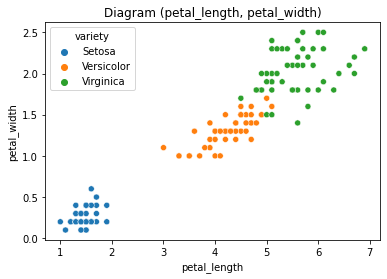

In [36]:
sns.scatterplot(data = df_new_pnd, x = "petal_length", y = "petal_width", hue = "variety").set(title='Diagram (petal_length, petal_width)')
plt.show()

### 5. Посмотрите внимательно на получившийся график и сформируйте правило вида
ЕСЛИ ЗНАЧЕНИЕ ПАРАМЕТРА A < ЗНАЧЕНИЕ, ТО IRIS ОТНОСИТСЯ К КЛАССУ SETOSA - ИНАЧЕ К КАКОМУ-ТО ДРУГОМУ (НАЗОВЕМ, ЕГО НАПРИМЕР UNKNOWN).

ПРАВИЛО: Если petal_length < 2, а petal_width < 0.8, то это Setosa, в другом случае Unknown.

### 6. При помощи команд withColumn, when, otherwise создайте в датафрейме новую колонку с таким предсказанием.

In [37]:
df_new_pred = df_new.withColumn("predict", when((df_new.petal_length < 2) & (df_new.petal_width < 0.8), lit("Setosa")).otherwise(lit("Unknown")))
df_new_pred.show(10)

+------------+-----------+------------+-----------+-------+-------+
|sepal_length|sepal_width|petal_length|petal_width|variety|predict|
+------------+-----------+------------+-----------+-------+-------+
|         5.1|        3.5|         1.4|        0.2| Setosa| Setosa|
|         4.9|        3.0|         1.4|        0.2| Setosa| Setosa|
|         4.7|        3.2|         1.3|        0.2| Setosa| Setosa|
|         4.6|        3.1|         1.5|        0.2| Setosa| Setosa|
|         5.0|        3.6|         1.4|        0.2| Setosa| Setosa|
|         5.4|        3.9|         1.7|        0.4| Setosa| Setosa|
|         4.6|        3.4|         1.4|        0.3| Setosa| Setosa|
|         5.0|        3.4|         1.5|        0.2| Setosa| Setosa|
|         4.4|        2.9|         1.4|        0.2| Setosa| Setosa|
|         4.9|        3.1|         1.5|        0.1| Setosa| Setosa|
+------------+-----------+------------+-----------+-------+-------+
only showing top 10 rows



### 7. Проверьте качество своего предсказания.

In [38]:
df_new_pred.agg(
    count(when(col("variety") == "Setosa", True)), # сколько всего вариантов Setosa
    count(when((col("variety") == "Setosa") & (col("predict") == "Setosa"), True)), # совпадений
    count(when((col("variety") != "Setosa") & (col("predict") == "Setosa"), True)) # Подсчитайте количество строк, где Вы предсказали класс Setosa, а
                                                                                    #правильный класс был какой-то другой
    ).show()

+-------------------------------------------------+--------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|count(CASE WHEN (variety = Setosa) THEN true END)|count(CASE WHEN ((variety = Setosa) AND (predict = Setosa)) THEN true END)|count(CASE WHEN ((NOT (variety = Setosa)) AND (predict = Setosa)) THEN true END)|
+-------------------------------------------------+--------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|                                               50|                                                                        50|                                                                               0|
+-------------------------------------------------+--------------------------------------------------------------------------+------------------------------------------